In [1]:
import GPy
import numpy as np
import matplotlib.pyplot as plt

#from scipy.linalg import toeplitz

import time

# Div Free Kern

In [2]:
def divFreeKern(x, y, l):
    '''
    input: 
        - x and y two row vectors in R^n.
    output: 
        - k(x, y) div free kernel R^nxn matrix.
    '''
    #alphas usados en Wahlström: 0.3 , 1, 0.3
    alpha=1 #o sigma como le llaman en otros libros
    l=l #0.2
    n = len(x)
    
    xrf=np.matlib.repmat(x,n,1)
    xrc=xrf.T
    dxx1=xrf-xrc
    dxx=dxx1**2
    
    yrf=np.matlib.repmat(y,n,1)
    yrc=yrf.T
    dyy1=yrf-yrc
    dyy=dyy1**2
    
    dxy=dxx1*dyy1

    t1=(alpha**2)*np.e**(-1/2*(dxx+dyy)/l**2)
    
    t1=np.kron([[1,1],[1,1]],t1)
    
    t11=1/l**2-dyy/l**4
    t12=dxy/l**4
    t22=1/l**2-dxx/l**4
    
    t2= np.kron([[1,0],[0,0]],t11) + np.kron([[0,1],[1,0]],t12) + np.kron([[0,0],[0,1]],t22)
    K=t1*t2
    
    return(K)

In [29]:
##para generar arreglos más grandes
d = 2
nxGrid = 50

x = np.linspace(-2, 2., nxGrid)
y = np.linspace(-2, 2., nxGrid)

L = []
for i in range(nxGrid):
    for j in range(nxGrid):
        L.append([x[i], y[j]])

X = np.reshape(L, (nxGrid*nxGrid, d))


In [30]:
#para medir el tiempo
start_time = time.time()
l=0.3
K=divFreeKern(X[:,0],X[:,1],l)

elapsed_time = time.time() - start_time
print("Elapsed time: %.10f seconds." % elapsed_time)

divFreeK=K


Elapsed time: 10.5459232330 seconds.


In [33]:
#para medir el tiempo
start_time = time.time()

np.random.seed(0)
mu = np.zeros(d*nxGrid*nxGrid)
    
Z1 = np.random.multivariate_normal(mu, divFreeK, 4)
Z1.shape

elapsed_time = time.time() - start_time
print("Elapsed time: %.10f seconds." % elapsed_time)

Elapsed time: 71.2721617222 seconds.


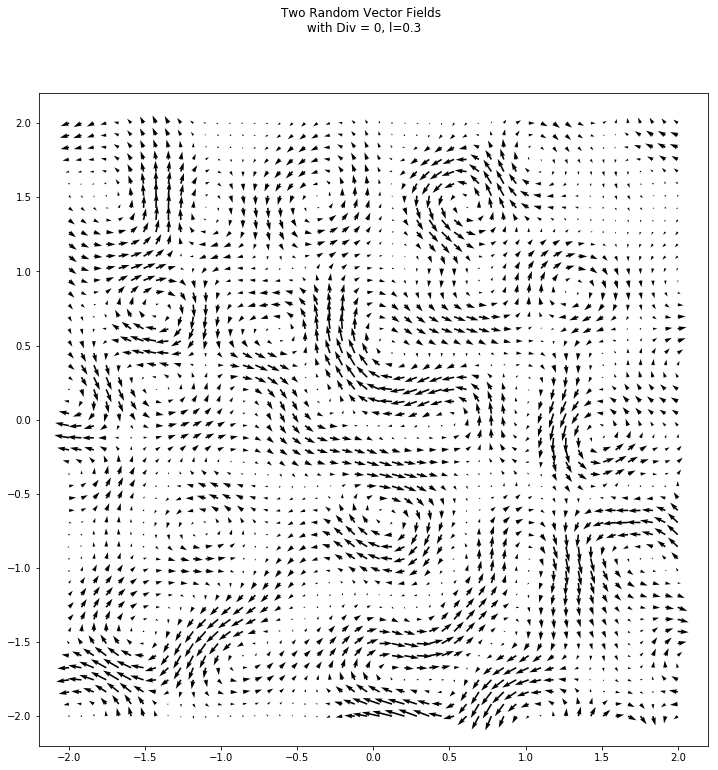

<Figure size 432x288 with 0 Axes>

In [34]:
npoints=nxGrid
dx0 = Z1[0][0:nxGrid*nxGrid]  ##Escribir en z1a
dy0 = Z1[0][nxGrid*nxGrid:d*nxGrid*nxGrid] ##Escribir en z1b

plt.figure(figsize=(12,12))
plt.quiver(X[:,0],X[:,1],dx0,dy0)
plt.suptitle('Two Random Vector Fields \n with Div = 0, l='+str(l))
#plt.savefig("DivZero l "+str(l)+".jpg", bbox_inches='tight',dpi = 1000)
plt.show()
plt.clf()


### Printing VTK

I try to write in a flat file (txt)

In [37]:
Z1.shape

with open("z1a.txt","w") as f:
    for t in Z1[0][0:npoints]:
        print(t,file=f)

with open("z1b.txt","w") as f:
    for t in Z1[0][npoints:2*npoints]:
        print(t,file=f)

Another form is :

In [38]:
# Printing VTKs with pyevtk https://github.com/pyscience-projects/pyevtk

#from pyevtk.hl import gridToVTK


# Making arrays

# 1. Divergence-free field
ww = dx0.reshape(nxGrid,nxGrid)
hh = dy0.reshape(nxGrid,nxGrid)

# 2D domain, so 1 slice
noSlices = 1

# Piling up 2D data
ww_s = np.dstack([ww]*noSlices)
hh_s = np.dstack([hh]*noSlices)


# Data need to be in Fortran order, see documentation
ww_s = np.asfortranarray(ww_s)
hh_s = np.asfortranarray(hh_s)

#print(ww_s.flags)
#print(mm_s.shape)

# Create export grid
ex = np.arange(0, nxGrid+1)
ey = np.arange(0, nxGrid+1)
ez = np.arange(0, noSlices)
#print(x)

# These also need to be in Fortran order
exx = np.asfortranarray(ex)
eyy = np.asfortranarray(ey)
ezz = np.asfortranarray(ez)
#print(hhStacked)
#print(ffStacked)

# Print rectilinear VTK file, i.e. VTR - div free field, in current directory
#gridToVTK("./VTK_files/dive", exx, eyy, ezz, cellData = {'compX': ww_s, 'compY': hh_s})

# These files can be visualised in VisIt.

# Curl Free Kern

In [3]:
def curlFreeKern(x, y, l):
    '''
    input: 
        - x and y two row vectors in R^n.
    output: 
        - k(x, y) div free kernel R^nxn matrix.
    '''
    
    #alphas usados en Wahlström: 0.3 , 1, 0.3
    alpha=1 #o sigma como le llaman en otros libros
    l=l#0.1
    n = len(x)
    
    xrf=np.matlib.repmat(x,n,1)
    xrc=xrf.T
    dxx1=xrf-xrc
    dxx=dxx1**2
    
    yrf=np.matlib.repmat(y,n,1)
    yrc=yrf.T
    dyy1=yrf-yrc
    dyy=dyy1**2
    
    z=np.zeros(n)
    zrf=np.matlib.repmat(z,n,1)
    zrc=zrf.T
    dzz1=zrf-zrc
    dzz=dzz1**2
    
    dxy=dxx1*dyy1
    dxz=dxx1*dzz1
    dyz=dyy1*dzz1

    #=np.array([[dyy,dxy],[dxy,dyy]])
    t1=(alpha**2)*np.e**(-1/2*(dxx+dyy+dzz)/l**2)
    t1=np.kron([[1,1,1],[1,1,1],[1,1,1]],t1)
    
    t11=np.kron([[1,0,0],[0,0,0],[0,0,0]], 1/l**2-dxx/l**4)
    t22=np.kron([[0,0,0],[0,1,0],[0,0,0]], 1/l**2-dyy/l**4)
    t33=np.kron([[0,0,0],[0,0,0],[0,0,1]], 1/l**2-dzz/l**4)
    t12=np.kron([[0,1,0],[1,0,0],[0,0,0]], -dxy/l**4)
    t13=np.kron([[0,0,1],[0,0,0],[1,0,0]], -dxz/l**4)
    t23=np.kron([[0,0,0],[0,0,1],[0,1,0]], -dyz/l**4)
    
    t2=t11+t22+t33+t12+t13+t23
    K=t1*t2
    
    return(K)

In [40]:
##para generar arreglos más grandes
d = 2
nxGrid = 50

x = np.linspace(-2, 2., nxGrid)
y = np.linspace(-2, 2., nxGrid)
print(x.shape)
#print('x=',x,'\n','y=',y)

L = []
for i in range(nxGrid):
    for j in range(nxGrid):
        L.append([x[i], y[j]])

X = np.reshape(L, (nxGrid*nxGrid, d))

print(X.shape)

(50,)
(2500, 2)


In [41]:
#para medir el tiempo
start_time = time.time()
l=0.5
K=curlFreeKern(X[:,0],X[:,1],l)

elapsed_time = time.time() - start_time
print("Elapsed time: %.10f seconds." % elapsed_time)

curlFreeK=K
curlFreeK.shape

Elapsed time: 37.3505737782 seconds.


(7500, 7500)

In [44]:
#para medir el tiempo
start_time = time.time()

np.random.seed(0)
mu = np.zeros((d+1)*nxGrid*nxGrid)
    
Z2 = np.random.multivariate_normal(mu, curlFreeK, 4)
print(Z2.shape)
Z2.shape

elapsed_time = time.time() - start_time
print("Elapsed time: %.10f seconds." % elapsed_time)

(4, 7500)
Elapsed time: 223.2910826206 seconds.


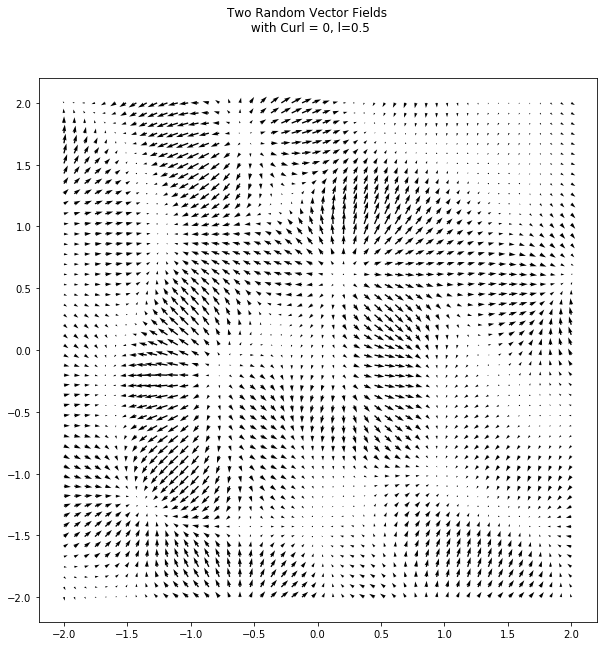

<Figure size 432x288 with 0 Axes>

In [45]:
npoints=nxGrid
dx0 = Z2[0][0:nxGrid*nxGrid]  ##Escribir en z2a
dy0 = Z2[0][nxGrid*nxGrid:d*nxGrid*nxGrid] ##Escribir en z2b
dz0 = Z2[0][d*nxGrid*nxGrid:(d+1)*nxGrid*nxGrid] ##Escribir en z2b

plt.figure(figsize=(10,10))
plt.quiver(X[:,0],X[:,1],dx0,dy0)
plt.suptitle('Two Random Vector Fields \n with Curl = 0, l='+str(l))
#plt.savefig("CurlZero l "+str(l)+".jpg", bbox_inches='tight',dpi = 1000)
plt.show()
plt.clf()
#print(dx0)

### Printing VTK

In [49]:
# Printing VTKs with pyevtk https://github.com/pyscience-projects/pyevtk

#from pyevtk.hl import gridToVTK

# Making arrays

# 2. Curl-free field
mm = dx0.reshape(nxGrid,nxGrid)
pp = dy0.reshape(nxGrid,nxGrid)

# 2D domain, so 1 slice
noSlices = 1

# Piling up 2D data
mm_s = np.dstack([mm]*noSlices)
pp_s = np.dstack([pp]*noSlices)

# Data need to be in Fortran order, see documentation
mm_s = np.asfortranarray(mm_s)
pp_s = np.asfortranarray(pp_s)

#print(ww_s.flags)
#print(mm_s.shape)

# Create export grid
ex = np.arange(0, nxGrid+1)
ey = np.arange(0, nxGrid+1)
ez = np.arange(0, noSlices)
#print(x)

# These also need to be in Fortran order
exx = np.asfortranarray(ex)
eyy = np.asfortranarray(ey)
ezz = np.asfortranarray(ez)
#print(hhStacked)
#print(ffStacked)

# Print rectilinear VTK file, i.e. VTR - curl free field, in current directory
#gridToVTK("./VTK_files/curl", exx, eyy, ezz, cellData = {'compX': mm_s, 'compY': pp_s})

# These files can be visualised in VisIt.

In [50]:
#from sympy.physics.vector import ReferenceFrame

#R = ReferenceFrame('R')

#print(R)

#from sympy.physics.vector import curl

#field = R[0]*R[1]*R[2]*R.x

#print(R.x)

#curl(field, R)

## Derivatives and Plots

In [51]:
# Derivatives: Method 2
# Here I use the functions below (by Finney).

# Functions taken from https://github.com/bryant-finney/vector-calculus
# Method works for 2D data, 1st component is real, 2nd component is im.

def divergence(x, y, A):
    if len(np.shape(x)) is not 1:
        raise ValueError("x values should be a 1 dimensional array.")
    if len(np.shape(y)) is not 1:
        raise ValueError("y values should be a 1 dimensional array.")
    if np.shape(A) != (len(y), len(x)):
        raise ValueError("A should be a 2D array of size len(y) by len(x).")
    # preallocate output array
    d = np.zeros((len(y) - 1, len(x) - 1))
    
    # loop through rows and take the partial derivative of the y component 
    # with respect to x
    for i, row in enumerate(A):
        if i is len(y) - 1:
            break
        d[i, :] += np.diff(np.real(row)) / np.diff(x)
    
    # loop through columns and take the partial derivative of the x component 
    # with respect to y
    for i, col in enumerate(A.T):
        if i is len(x) - 1:
            break
        d[:, i] += np.diff(np.imag(col)) / np.diff(y)

    return d
    
def curl(x, y, A):
    if len(np.shape(x)) is not 1:
        raise ValueError("x values should be a 1 dimensional array.")
    if len(np.shape(y)) is not 1:
        raise ValueError("y values should be a 1 dimensional array.")
    if np.shape(A) != (len(y), len(x)):
        raise ValueError("A should be a 2D array of size len(y) by len(x).")
    # preallocate output array
    c = np.zeros((len(y) - 1, len(x) - 1))
    # loop through rows and take the partial derivative of the y component 
    # with respect to x
    for i, row in enumerate(A):
        if i is len(y) - 1:
            break
        c[i, :] += np.diff(np.imag(row)) / np.diff(x)
    # loop through columns and take the partial derivative of the x component 
    # with respect to y
    for i, col in enumerate(A.T):
        if i is len(x) - 1:
            break
        c[:, i] -= np.diff(np.real(col)) / np.diff(y)

    return c

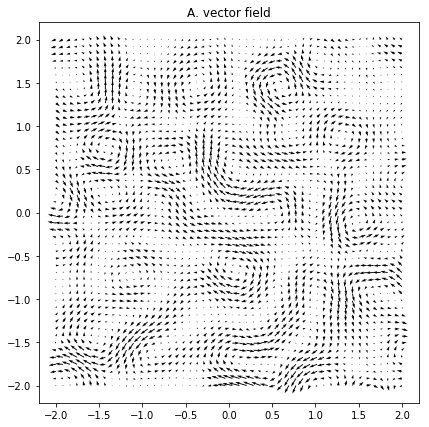

A. div promedio: 
-0.028349117022851228
A. curl promedio: 
-0.14198400005659015


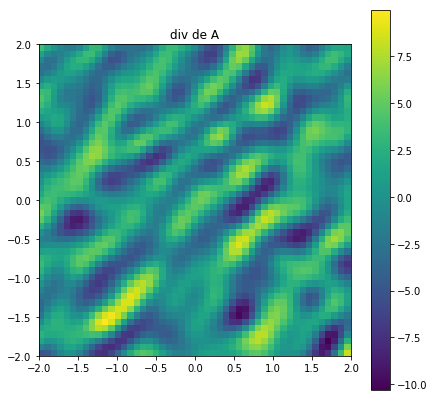

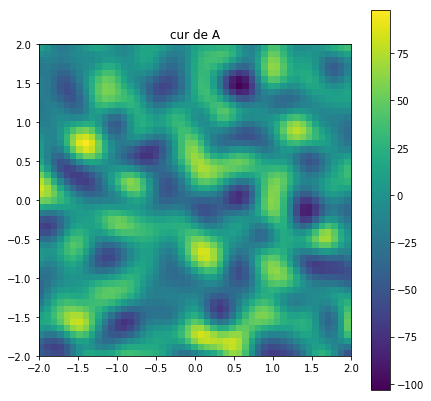

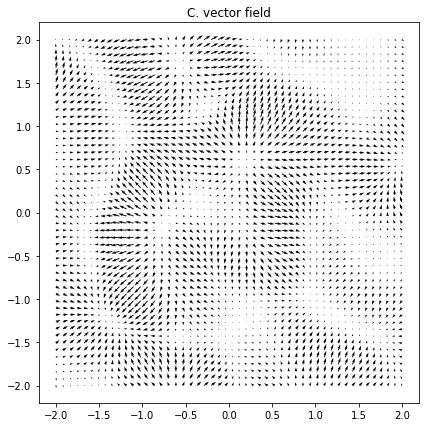

C. div promedio: 
-1.1334749302315639
C. curl promedio: 
-0.020801886603096516


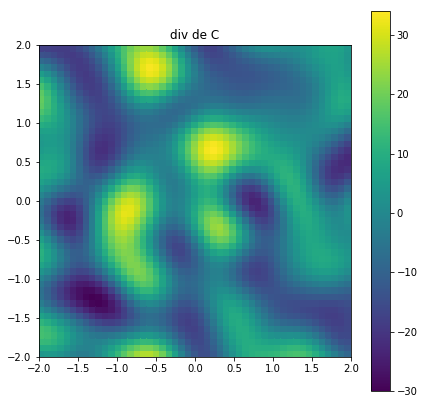

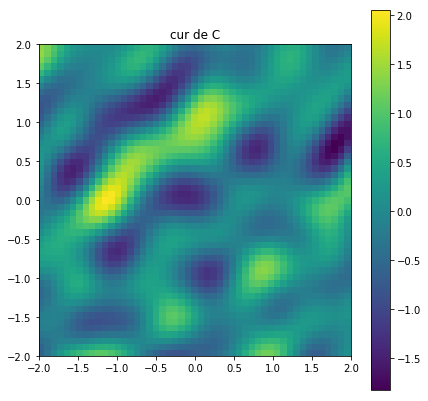

In [52]:
# Derivatives: Method 1
# Here I calculate the derivatives by hand, using np.diff, so 1st order.

gx, gy = np.meshgrid(x, y)

# Divergence of the vector fields
divA = (np.diff(hh,axis=1)[:-1,:]/np.diff(gx,axis=1)[:-1,:]) + \
      (np.diff(ww,axis=0)[:,:-1]/np.diff(gy,axis=0)[:,:-1])

divC = (np.diff(pp,axis=1)[:-1,:]/np.diff(gx,axis=1)[:-1,:]) + \
      (np.diff(mm,axis=0)[:,:-1]/np.diff(gy,axis=0)[:,:-1])

# Curl of the vector fields
curA = (np.diff(ww,axis=1)[:-1,:]/np.diff(gx,axis=1)[:-1,:]) - \
      (np.diff(hh,axis=0)[:,:-1]/np.diff(gy,axis=0)[:,:-1])

curC = (np.diff(mm,axis=1)[:-1,:]/np.diff(gx,axis=1)[:-1,:]) - \
      (np.diff(pp,axis=0)[:,:-1]/np.diff(gy,axis=0)[:,:-1])

#Plots
plt.figure(figsize=(7,7))
plt.title("A. vector field")
plt.quiver(gy, gx, ww, hh) #I had to reverse gy <-> gx ?? Not sure how python indexes.
plt.gca().set_aspect("equal") 
plt.show()

plt.figure(figsize=(7,7))
plt.title("div de A")
plt.pcolormesh(gy, gx, divA)
plt.colorbar()
plt.gca().set_aspect("equal")
#plt.clim(-0.1,0.1)
plt.savefig("./Outputs/divA1.jpg", bbox_inches="tight") 

plt.figure(figsize=(7,7))
plt.title("cur de A")
plt.pcolormesh(gy, gx, curA)
plt.colorbar()
plt.gca().set_aspect("equal") 
#plt.clim(-5,5)

########################################################

print("A. div promedio: ")
print(np.mean(divA))
print("A. curl promedio: ")
print(np.mean(curA))

plt.figure(figsize=(7,7))
plt.title("C. vector field")
plt.quiver(gy, gx, mm, pp)
plt.gca().set_aspect("equal") 
plt.show()

plt.figure(figsize=(7,7))
plt.title("div de C")
plt.pcolormesh(gy, gx, divC)
plt.colorbar()
plt.gca().set_aspect("equal") 
#plt.clim(-5,5)

plt.figure(figsize=(7,7))
plt.title("cur de C")
plt.pcolormesh(gy, gx, curC)
plt.colorbar()
plt.gca().set_aspect("equal")
#plt.clim(-0.1,0.1)
plt.savefig("./Outputs/curC1.jpg", bbox_inches="tight") 

print("C. div promedio: ")
print(np.mean(divC))
print("C. curl promedio: ")
print(np.mean(curC))

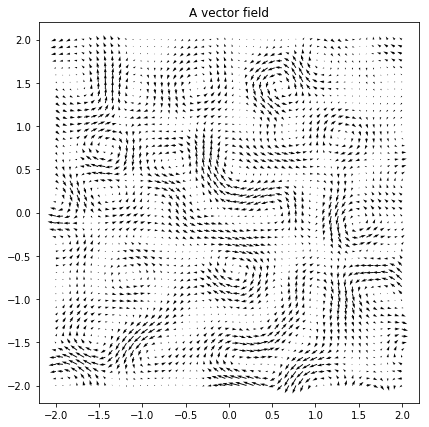

A. div promedio: 
-0.028349117022851228
A. curl promedio: 
-0.14198400005659015


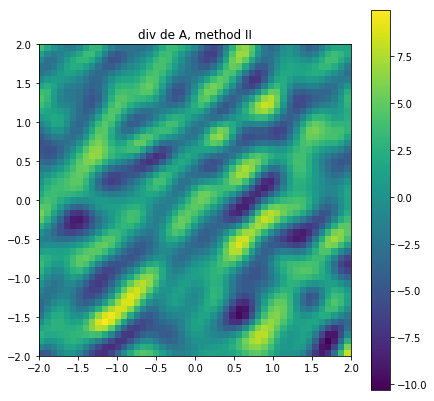

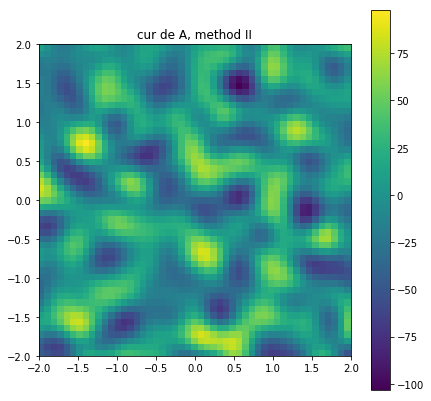

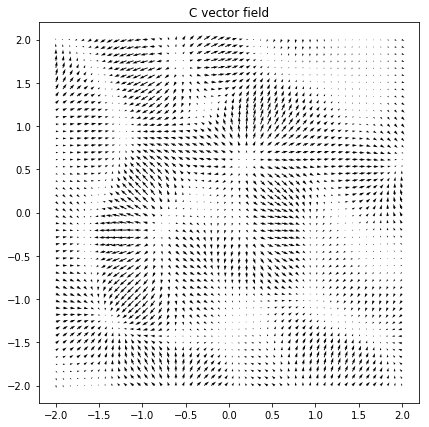

C. div promedio: 
-1.1334749302315639
C. curl promedio: 
-0.020801886603096516


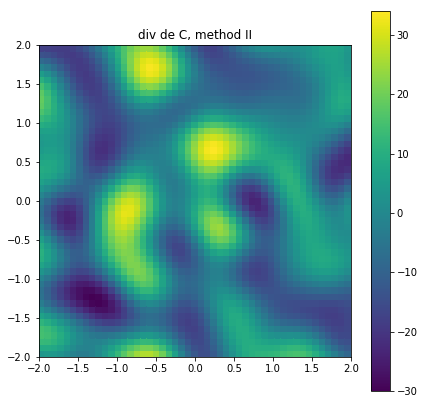

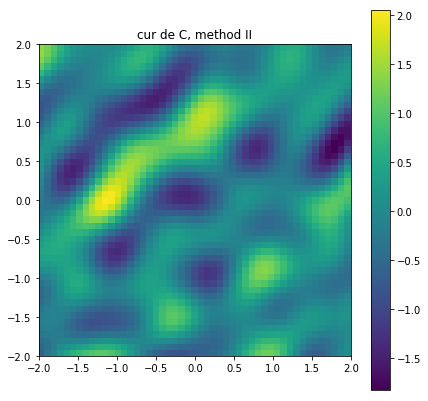

In [57]:
# Numbers are treated as complex numbers

# We create two arrays, then we fill them with the components. The x component goes with i.
AAA = CCC = np.zeros((len(x), len(y)), dtype=np.complex128)

# Divergence-free field
AAA = np.array((np.array(hh)+1j*np.array(ww)), dtype=np.complex128)

# Curl-free field
CCC = np.array((np.array(pp)+1j*np.array(mm)), dtype=np.complex128)


DiveA = divergence(x, y, AAA)
DiveC = divergence(x, y, CCC)

CurlA = curl(x, y, AAA)
CurlC = curl(x, y, CCC)


plt.figure(figsize=(7,7))
plt.title("A vector field")
plt.quiver(gy, gx, ww, hh) #I had to reverse gy <-> gx ?? Not sure how python indexes.
plt.gca().set_aspect("equal") 
plt.show()

plt.figure(figsize=(7,7))
plt.title("div de A, method II")
plt.pcolormesh(gy, gx, DiveA)
plt.colorbar()
plt.gca().set_aspect("equal")
#plt.clim(-0.1,0.1)
plt.savefig("./Outputs/divA2.jpg", bbox_inches="tight") 

plt.figure(figsize=(7,7))
plt.title("cur de A, method II")
plt.pcolormesh(gy, gx, CurlA)
plt.colorbar()
plt.gca().set_aspect("equal") 
#plt.clim(-5,5)

print("A. div promedio: ")
print(np.mean(DiveA))
print("A. curl promedio: ")
print(np.mean(CurlA))

############################################

plt.figure(figsize=(7,7))
plt.title("C vector field")
plt.quiver(gy, gx, mm, pp)
plt.gca().set_aspect("equal") 
plt.show()

plt.figure(figsize=(7,7))
plt.title("div de C, method II")
plt.pcolormesh(gy, gx, DiveC)
plt.colorbar()
plt.gca().set_aspect("equal") 
#plt.clim(-5,5)

plt.figure(figsize=(7,7))
plt.title("cur de C, method II")
plt.pcolormesh(gy, gx, CurlC)
plt.colorbar()
plt.gca().set_aspect("equal")
#plt.clim(-0.1,0.1)
plt.savefig("./Outputs/curC2.jpg", bbox_inches="tight") 

print("C. div promedio: ")
print(np.mean(DiveC))
print("C. curl promedio: ")
print(np.mean(CurlC))

In [54]:
# Incomplete


#a = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
#b = np.diff(a)
#p = np.diff(np.diff(a))
#q = len(a)

#J=[]
#for n in range(q):
#    d = np.array(a[n]) - np.array(a[n-1])
    #print(d)
#    J.append(d)

#myarray = np.asarray(J)[-q+1:]

#print(n)
#print(b)
#print(p)
#print(myarray)
#print(J)
#print(b.shape)
#print(J.shape)

#print(myarray.shape)

In [55]:
#a = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
#b = np.diff(a)
#q = len(a)

#J=[]
#for n in range(q):
#    d = np.array(a[n]) - np.array(a[n-2])
    #print(d)
#    J.append(d)

#myarray = np.asarray(J)[-q+2:]

#print(n)
#print(b)
#print(myarray)
#print(J)
#print(b.shape)
#print(J.shape)

#print(myarray.shape)

In [56]:
#from numpy import linspace, meshgrid
#import matplotlib.pyplot as plt

# Argumentwerte als 1D Arrays erzeugen
#x_1d = linspace(-2,2,801)
#y_1d = linspace(-2,1,601)

#x_1d = np.linspace(-2, 2, nxGrid)
#y_1d = np.linspace(-2, 2, nxGrid)


#print(N)

#x, y = meshgrid(x_1d, y_1d)
#print(x.shape)


#print(x.shape)
#print(y.shape)
#U=ww
#V=hh

#print(U.shape)
#print(V.shape)

#div = (diff(U,axis=1)/diff(x,axis=1))[:-1,:] + (diff(V,axis=0)/diff(y,axis=0))[:,:-1]
#div = (diff(U,axis=1)[:-1,:]/diff(x,axis=1)[:-1,:]) + (diff(V,axis=0)[:,:-1]/diff(y,axis=0)[:,:-1])

#Jx=[]
#Jy=[]
#P=[]
#E=[]

#for i in range(N):
#    for n in range(N):
#        dx = np.array(x[i][n]) - np.array(x[i][n-2])
#        dy = np.array(y[i][n]) - np.array(y[i][n-2])
#        s = np.array(ww[i][n]) - np.array(ww[i][n-2])
#        t = np.array(hh[i][n]) - np.array(hh[i][n-2])
#        print(dx)
#        Jx.append(dx)
#        Jy.append(dy)
#        P.append(s)
#        E.append(t)

    
#myarrayx = np.asarray(Jx)[-N+2:]
#myarrayy = np.asarray(Jy)[-N+2:]
#myarrayx2 = np.asarray(P)[-N+2:]
#myarrayy2 = np.asarray(E)[-N+2:]

#print(myarrayx.shape)
#print(myarrayy.shape)
#print(myarrayx2.shape)
#print(myarrayy2.shape)

#cur = (diff(U,axis=1)[:-1,:]/diff(y,axis=0)[:,:-1]) + (diff(V,axis=0)[:,:-1]/diff(x,axis=1)[:-1,:])

#cur =  myarrayx2/myarrayx + myarrayy2/myarrayy